In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

##### Récupération du chemin d'accès des images
# Un dossier parent "root"
# Dans ce dossier, 8 sous-dossiers, un pour chaque type de cellule

files = []
ids = []
labels = []

path_gen = r".\Sane"
path_loc = [r"\basophil",r"\eosinophil",r"\erythroblast",r"\ig",
            r"\lymphocyte",r"\monocyte",r"\neutrophil",r"\platelet"]

for x in path_loc:
    path = path_gen + x
    files.extend([join(path, f)  for f in listdir(path)])

##### Création d'un DataFrame
df = pd.DataFrame(columns = ["path", "id", "label"])

df["path"] = files
df["id"] = df["path"].apply(lambda x : x.split('_')[1][:-4])
df["label"] = df["path"].apply(lambda x : x.split('_')[0].split('\\')[-1])

## Attention, certaines images ont le même id

FileNotFoundError: [Errno 2] No such file or directory: '.\\Sane\\basophil'

In [2]:
# Fusion des "sous-classes" : MY, MMY & PMY => IG  ;  SNE, NEUTROPHIL => BNE
df["label"] = df["label"].replace(to_replace = ["SNE","NEUTROPHIL","MY","MMY","PMY"], 
                                  value = ["BNE","BNE","IG","IG","IG"])

# Décompte des cellules par catégories
print(df["label"].value_counts())

# Stockage de chacun des 8 labels dans la liste classes
classes = df["label"].value_counts().index.to_list()

# Aperçu du DataFrame
df.head()

BNE         3329
EO          3117
IG          2895
PLATELET    2348
ERB         1551
MO          1420
BA          1218
LY          1214
Name: label, dtype: int64


,path,id,label
0,.\Sane\basophil\BA_100102.jpg,100102,BA
1,.\Sane\basophil\BA_101381.jpg,101381,BA
2,.\Sane\basophil\BA_101611.jpg,101611,BA
3,.\Sane\basophil\BA_102039.jpg,102039,BA
4,.\Sane\basophil\BA_102750.jpg,102750,BA


Type de img :  <class 'numpy.ndarray'>
Shape de img :  (363, 360, 3)


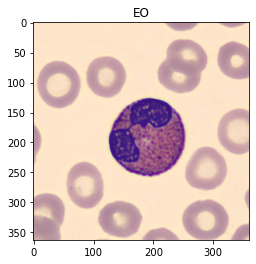

In [3]:
###### Afficher une image au hasard ######
i = np.random.randint(0,len(df))
img = plt.imread(df.loc[i,"path"])

# Caractéristiques de l'image :
# Images RGB : (M,N,3)   M*N pixels, 3 canaux (rouge, vert, bleu)
print("Type de img : ",type(img))
print("Shape de img : ",img.shape)

pix_height = img.shape[0]
pix_width = img.shape[1]

fig0 = plt.figure()
plt.imshow(img)
plt.title(df.loc[i,"label"])
plt.show()

In [4]:
###### Taille des images ######
M = []
N = []
for file in df["path"]:
    img = plt.imread(file)
    M.append(img.shape[0]) 
    N.append(img.shape[1])
    
df["height"] = M
df["width"] = N

In [5]:
print(df["height"].value_counts().sort_index())
print("--------------------------------------")
print(df["width"].value_counts().sort_index())
print("--------------------------------------")

# Quelques surprises au niveau de la taille des images... On rabote ?
pix_height = min(df["height"])
pix_width = min(df["width"])
print("Min Height : %i ; Min Width : %i"%(min(df["height"]),min(df["width"])))
print("--------------------------------------")

# Utile pour plus loin (cf. cellules "moyennes")
pix_height = min(pix_height,pix_width)
pix_width = pix_height

print("Min Height : %i ; Min Width : %i"%(pix_width, pix_height))

360      201
361        2
363    16639
369      250
Name: height, dtype: int64
--------------------------------------
359        1
360    16839
361        1
362        1
366      250
Name: width, dtype: int64
--------------------------------------
Min Height : 360 ; Min Width : 359
--------------------------------------
Min Height : 359 ; Min Width : 359


Text(0, 0.5, 'Number of images')

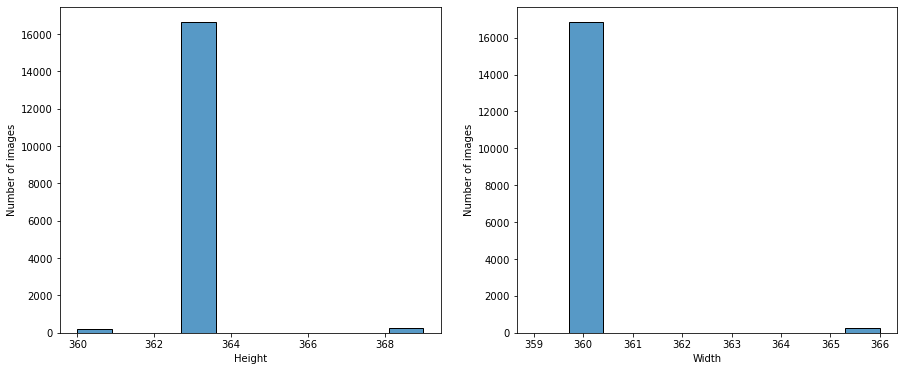

In [6]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.histplot(x = "height", bins = 10, data = df)
plt.xlabel('Height')
plt.ylabel('Number of images')

plt.subplot(1,2,2)
sns.histplot(x = "width", bins = 10, data = df)
plt.xlabel('Width')
plt.ylabel('Number of images')

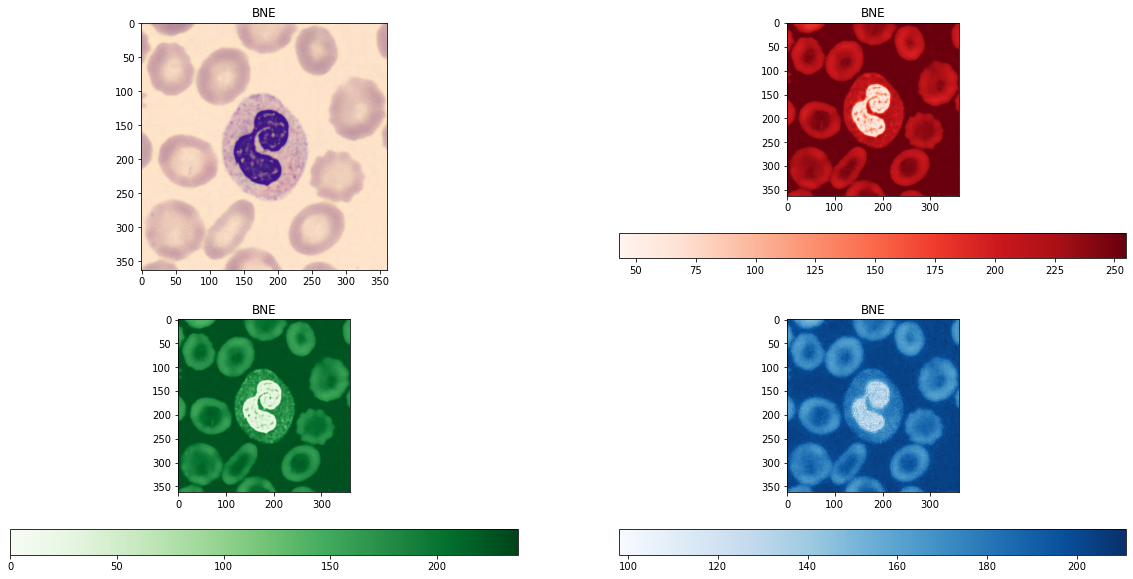

In [7]:
###### Décomposition en trois canaux ######

i = np.random.randint(0,len(df))
img = plt.imread(df.loc[i,"path"])

#img = plt.imread('afqqm.jpg')  ## TEST validité décomposition RGB

fig4 = plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title(df.loc[i,"label"])

colors = ['Reds','Greens','Blues']
for j in range(3):
    canal = img[:,:,j]
    plt.subplot(2,2,j+2)
    plt.imshow(canal, cmap = colors[j])
    plt.title(df.loc[i,"label"])
    plt.colorbar(orientation = "horizontal")

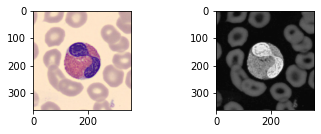

In [8]:
###### Analyse de la luminosité, classe par classe ###### 
## Certaines cellules ont une teinte différente par rapport aux autres (cf. éosinophiles) : dans ce cas une
## différence de teinte n'est pas un biais mais un possible critère de sélection...

## Passage en noir et blanc pour vérifier s'il y a différence de luminosité entre chaque catégorie de cellule.

i = np.random.randint(0,len(df))
img = plt.imread(df.loc[i,"path"])
img_grey = img.mean(axis = 2)                 # On moyenne sur les 3 canaux pour avoir les niveaux de gris

fig6 = plt.figure()
fig6.add_subplot(2,2,1)
plt.imshow(img)

fig6.add_subplot(2,2,2)
plt.imshow(img_grey, cmap = 'binary')

#fig6.add_subplot(2,2,3)

#fig6.add_subplot(2,2,4)

# Le noyau de la cellule d'intérêt vire au blanc : peut-être une piste pour se débarrasser des globules rouges en fond.

In [9]:
## Calcul de la luminosité moyenne de chaque image

lum = []
for file in df["path"]:
    lum.append(np.mean(plt.imread(file)))
    
df["mean_brightness"] = lum
df.head()

,path,id,label,height,width,mean_brightness
0,.\Sane\basophil\BA_100102.jpg,100102,BA,363,360,199.553548
1,.\Sane\basophil\BA_101381.jpg,101381,BA,363,360,194.144151
2,.\Sane\basophil\BA_101611.jpg,101611,BA,363,360,194.228801
3,.\Sane\basophil\BA_102039.jpg,102039,BA,363,360,190.404752
4,.\Sane\basophil\BA_102750.jpg,102750,BA,363,360,201.782022


<AxesSubplot:xlabel='mean_brightness', ylabel='Density'>

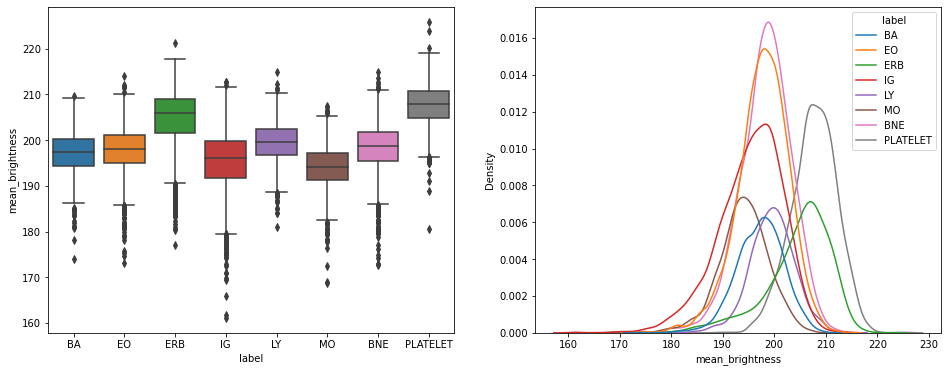

In [10]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
sns.boxplot(x = "label", y = "mean_brightness", data = df)

plt.subplot(1,2,2)
sns.kdeplot(x = "mean_brightness", hue = "label", data = df)

# Biais de luminosité moyenne pour ERB (erythroblastes), PLATELET (plaquettes), MO (monocytes, en moindre mesure)
# Outliers (faible luminosité) dans toutes les classes.

<AxesSubplot:xlabel='mean_brightness', ylabel='Density'>

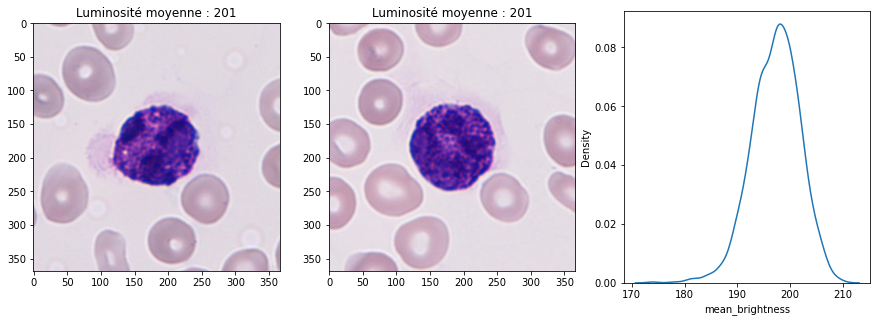

In [11]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.imshow(plt.imread(r".\Sane\basophil\BA_4744.jpg"))
plt.title("Luminosité moyenne : %i"%(df[df["path"]==r".\Sane\basophil\BA_4744.jpg"]["mean_brightness"]))

plt.subplot(1,3,2)
plt.imshow(plt.imread(r".\Sane\basophil\BA_6162.jpg"))
plt.title("Luminosité moyenne : %i"%(df[df["path"]==r".\Sane\basophil\BA_6162.jpg"]["mean_brightness"]))

plt.subplot(1,3,3)
sns.kdeplot(x = "mean_brightness", data = df[df["label"] == "BA"])

## Les images dont le fond est plutôt violet/gris ne sont forcément pas des outliers et correspondent à des
## luminosités plutôt élevées.

## Si on regarde la kde des basophiles (3e figure ci-dessous), on voit 2 pics pratiquement confondus... 
## Le pic de luminosité "élevée" semble correspondre aux images au fond violet ~ gris.

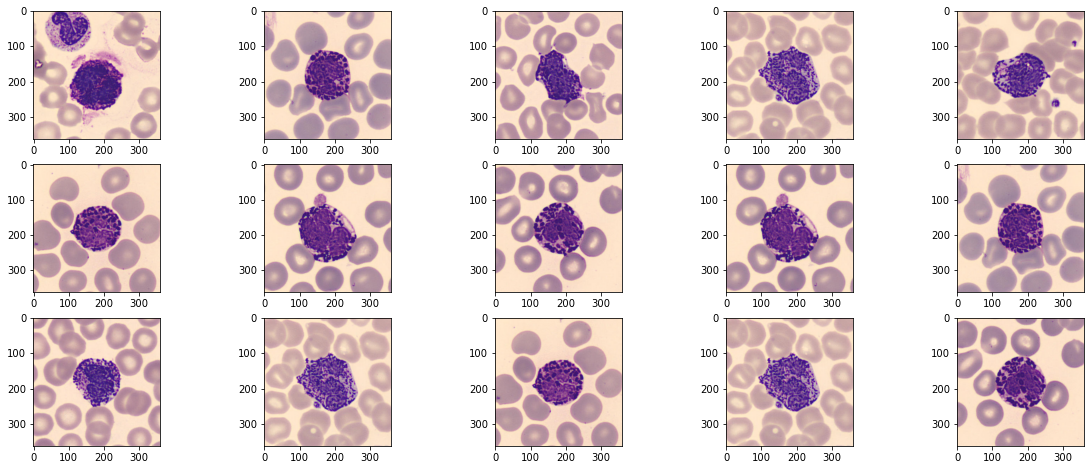

In [12]:
# On peut afficher les images de quelques outliers chez les basophiles (BA)

import random

df_sombre_BA = df[(df["mean_brightness"] <= 185) & (df["label"] == "BA")]
images_BA = random.choices(df_sombre_BA.index, k = 15)

plt.figure(figsize = (20,8))

for i, f_BA in zip(range(15), images_BA):
 
    img_BA = plt.imread(df.loc[f_BA,"path"])
    
    plt.subplot(3,5,i+1)
    plt.imshow(img_BA)
    
## Les outliers de faible luminosité sont des images pour lesquelles il y a plusieurs basophiles, ou beaucoup de
## globules rouges.

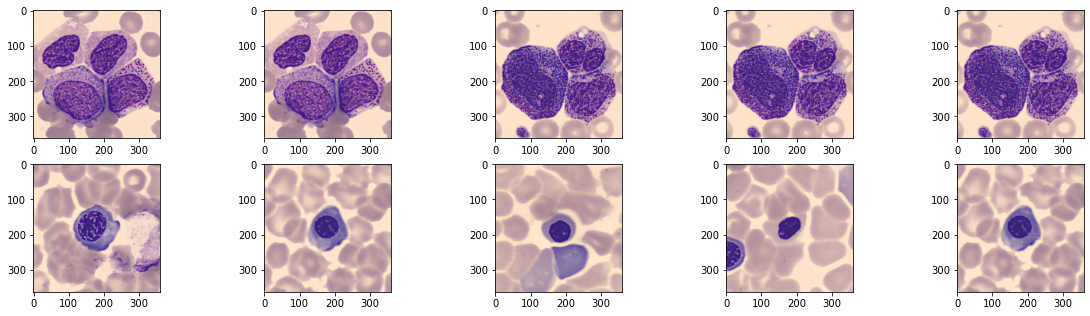

In [13]:
# On affiche des outliers dans d'autres classes de cellules : IG, ERB

df_sombre_IG = df[(df["mean_brightness"] <= 170) & (df["label"] == "IG")]
df_sombre_ERB = df[(df["mean_brightness"] <= 185) & (df["label"]== "ERB")]

images_IG = random.choices(df_sombre_IG.index, k = 5)
images_ERB = random.choices(df_sombre_ERB.index, k = 5)

plt.figure(figsize = (20,8))

for i, f_IG, f_ERB in zip(range(5), images_IG, images_ERB):
 
    img_IG = plt.imread(df.loc[f_IG,"path"])
    img_ERB = plt.imread(df.loc[f_ERB,"path"])
    
    plt.subplot(3,5,i+1)
    plt.imshow(img_IG)
    
    plt.subplot(3,5,i+6)
    plt.imshow(img_ERB)
    
# Plusieurs raisons pour les outliers en luminosité :
# - plusieurs cellules d'intérêt (couleur vive) dans l'image
# - beaucoup de globules rouges sur l'image

In [14]:
#print(df.groupby("label")["mean_brightness"].describe())

brightness = pd.DataFrame(df.groupby(by = "label")["mean_brightness"].mean())
brightness["class_std"] = df.groupby(by = "label")["mean_brightness"].std()

brightness = brightness.rename({"mean_brightness":"class_mean"}, axis = 1)
brightness

,class_mean,class_std
label,,
BA,197.216984,4.543105
BNE,198.343272,5.039859
EO,197.760774,4.978062
ERB,204.655257,6.353223
IG,195.386905,6.273297
LY,199.571812,4.292060
MO,194.063900,4.823247
PLATELET,207.697901,4.397455


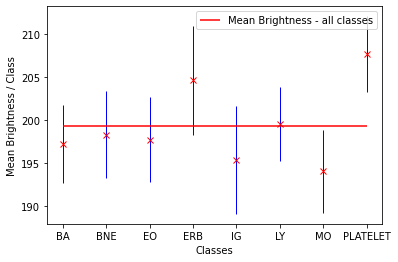

In [15]:
# Moyenne de la luminosité pour chaque classe de cellules + barres d'erreur

plt.errorbar(x = brightness.index, y = brightness["class_mean"], yerr = brightness["class_std"],
             marker = 'x', elinewidth = 1, linewidth = 0, ecolor = 'blue', color = 'red')

plt.hlines(y = brightness["class_mean"].mean(), xmin = 'BA', xmax = 'PLATELET', 
           color = "red", label = 'Mean Brightness - all classes')
plt.xlabel('Classes')
plt.ylabel('Mean Brightness / Class')
plt.legend()
plt.show()

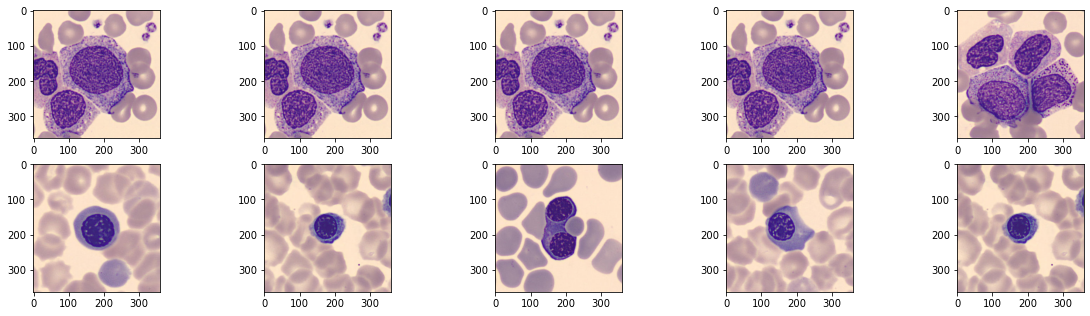

In [16]:
import random

df_sombre_IG = df[(df["mean_brightness"] <= 170) & (df["label"] == "IG")]
df_sombre_ERB = df[(df["mean_brightness"] <= 185) & (df["label"]== "ERB")]

images_IG = random.choices(df_sombre_IG.index, k = 5)
images_ERB = random.choices(df_sombre_ERB.index, k = 5)

plt.figure(figsize = (20,8))

for i, f_IG, f_ERB in zip(range(5), images_IG, images_ERB):
 
    img_IG = plt.imread(df.loc[f_IG,"path"])
    img_ERB = plt.imread(df.loc[f_ERB,"path"])
    
    plt.subplot(3,5,i+1)
    plt.imshow(img_IG)
    
    plt.subplot(3,5,i+6)
    plt.imshow(img_ERB)
    
# Plusieurs raisons pour les outliers en luminosité :
# - plusieurs cellules d'intérêt (couleur vive) dans l'image
# - beaucoup de globules rouges sur l'image

In [17]:
#print(df.groupby("label")["mean_brightness"].describe())

brightness = pd.DataFrame(df.groupby(by = "label")["mean_brightness"].mean())
brightness["class_std"] = df.groupby(by = "label")["mean_brightness"].std()

brightness = brightness.rename({"mean_brightness":"class_mean"}, axis = 1)
brightness

,class_mean,class_std
label,,
BA,197.216984,4.543105
BNE,198.343272,5.039859
EO,197.760774,4.978062
ERB,204.655257,6.353223
IG,195.386905,6.273297
LY,199.571812,4.292060
MO,194.063900,4.823247
PLATELET,207.697901,4.397455


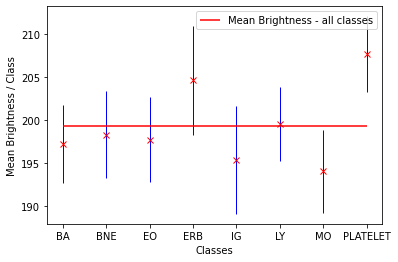

In [18]:
## Moyenne de la luminosité pour chaque classe de cellules + barres d'erreur

plt.errorbar(x = brightness.index, y = brightness["class_mean"], yerr = brightness["class_std"],
             marker = 'x', elinewidth = 1, linewidth = 0, ecolor = 'blue', color = 'red')

plt.hlines(y = brightness["class_mean"].mean(), xmin = 'BA', xmax = 'PLATELET', 
           color = "red", label = 'Mean Brightness - all classes')
plt.xlabel('Classes')
plt.ylabel('Mean Brightness / Class')
plt.legend()
plt.show()